## Classifications (Random Forest and Neural Network)

In [1]:
# import packages we will use
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint as sp_randint

# packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# split data
from sklearn.model_selection import train_test_split

# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model evaluation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin   # avoid fit_transform()

# NN models
import tensorflow as tf
from tensorflow import keras

# save model
from sklearn.externals import joblib
from tensorflow.python.keras.models import load_model

In [2]:
# record time of fitting
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        

# select numerical featuers and categorical featrues from dataframe
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# help function to plot ROC curve for randomforest
def ROC_Curve_rf(rf, X_test, y_test):
    y_scores = rf.predict_proba(X_test)[:, 1]   # prob of positive class
    false_positive, true_positive, _ = roc_curve(y_test, y_scores)
    
    auc = roc_auc_score(y_test, y_scores)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()
    
    return

# help function to plot ROC curve for nn
def ROC_Curve_nn(nn, X_test, y_test):
    y_scores = nn.predict_proba(X_test)
    false_positive, true_positive, _ = roc_curve(y_test, y_scores)
    
    auc = roc_auc_score(y_test, y_scores)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Neural Network')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()
    
    return

def plot_feature_importances_rf(top_n):
    cat_encoder = cat_pipeline.named_steps['cat_encoder']
    temp = [list(x) for x in cat_encoder.categories_]
    cat_1hot_attribs = []
    for x in temp:
        cat_1hot_attribs += x
    attribs = num_attribs + cat_1hot_attribs

    # print('\n The top 20 important features and their relevant importances')
    # sorted(zip(rf_loaded.feature_importances_, attribs), reverse=True)[:20]

    lst = sorted(zip(rf_loaded.feature_importances_, attribs), reverse=True)[:top_n]
    lst_importances = []
    lst_features = []
    for x in lst:
        lst_importances.append(x[0])
        lst_features.append(x[1])

    # Plot the feature importances of the forest
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=lst_features, y=lst_importances)
    plt.title('Top 20 relative Important features')
    plt.show()
    
    return

def Plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, y,
                                                            cv = cv,
                                                            n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    # shows error from 0.6 to 1
    plt.ylim(.6, 1)
    plt.show()
    
    return

def transformation_test(test_data):
    # convert 'friday' to 'fri', 'wednesday' to 'wed' so on
    x35_mapping = {'wed':'wed', 'thurday':'thur', 'wednesday':'wed', 'thur':'thur', 'tuesday':'tue', 'friday':'fri',
                 'monday':'mon', 'fri':'fri'}
    test_data['x35'] = test_data['x35'].map(x35_mapping)
    
    # remove '$' and conver x41 to numerical values
    test_data['x41'] = test_data['x41'].str.replace('$', '', regex=False).astype('float64')
    
    # merge '-0.0%' and '0.0%' to '0.0%'
    x45_mapping = {'0.01%':'0.01%', '-0.01%':'-0.01%', '0.0%':'0.0%', '-0.0%':'0.0%', '0.02%':'0.02%', '-0.02%':'-0.02%',
              '-0.03%':'-0.03%', '0.03%':'0.03%', '-0.04%':'-0.04%', '0.04%':'0.04%'}
    test_data['x45'] = test_data['x45'].map(x45_mapping)
    
    test_prepared = full_pipeline.transform(test_data)
    
    return test_prepared

In [3]:
# load the train and test data
data = pd.read_csv('../Classification_RandomForest_NeuralNetwork/exercise_04_train.csv')
test = pd.read_csv('../Classification_RandomForest_NeuralNetwork/exercise_04_test.csv')

X = data.drop('y', axis=1)
y = data['y'].copy()

X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-17.933519,6.559220,2.422468,-27.737392,-12.080601,-3.892934,1.067466,0.935953,10.912007,1.107144,...,-94.582358,11.107047,0.093337,asia,0.421524,35.259947,8.994318,-21.000182,-0.686588,2.949106
1,-37.214754,10.774930,5.404072,21.354738,0.612690,-3.093533,6.161558,-0.972156,-5.222169,0.384969,...,1.474587,-1.991846,15.666187,asia,-0.132764,-1.192563,3.885024,-37.886523,-7.730392,-1.107330
2,0.330441,-19.609972,-1.331804,-15.153892,19.710240,19.077300,-1.747110,0.545570,-1.464609,3.670570,...,5.160726,17.132840,-5.333012,asia,1.432308,-3.435427,-1.133450,7.426099,-5.945534,1.316312
3,-13.709765,-8.011390,-1.536483,23.129497,27.880879,20.573991,-1.617689,4.129694,1.139928,2.912838,...,-26.589765,12.292136,4.177925,asia,0.733069,4.372964,15.529931,29.712153,2.240740,0.477195
4,-4.202598,7.076210,8.881550,23.600777,26.232164,-14.462320,3.231193,-0.069364,-7.310536,-2.268700,...,61.178243,6.218743,8.715709,asia,-0.977502,-30.085932,-8.244312,66.540331,-3.478195,-2.869702


In [4]:
print('\n Shape of training data:', data.shape)
print('\n Shape of test data:', test.shape)


 Shape of training data: (40000, 101)

 Shape of test data: (10000, 100)


In [5]:
# get a quick description of train data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 100 columns):
x0     39989 non-null float64
x1     39989 non-null float64
x2     39993 non-null float64
x3     39991 non-null float64
x4     39992 non-null float64
x5     39989 non-null float64
x6     39993 non-null float64
x7     39988 non-null float64
x8     39996 non-null float64
x9     39992 non-null float64
x10    39990 non-null float64
x11    39994 non-null float64
x12    39988 non-null float64
x13    39989 non-null float64
x14    39997 non-null float64
x15    39994 non-null float64
x16    39993 non-null float64
x17    39990 non-null float64
x18    39987 non-null float64
x19    39993 non-null float64
x20    39995 non-null float64
x21    39985 non-null float64
x22    39993 non-null float64
x23    39994 non-null float64
x24    39988 non-null float64
x25    39992 non-null float64
x26    39991 non-null float64
x27    39996 non-null float64
x28    39991 non-null float64
x29    39995 non-nul

In [6]:
print('y has missing value?', y.isnull().any())

y has missing value? False


## Preprocess categorical data

In [7]:
# see the distribution and info for the categorical data
X.describe(include=['O'])

,x34,x35,x41,x45,x68,x93
count,39992,39989,39994,39995,39989,39993
unique,10,8,37813,10,12,3
top,volkswagon,wed,$-100.95,0.01%,July,asia
freq,12557,14829,4,9577,11146,35434


Text(0.5,1,'x34')

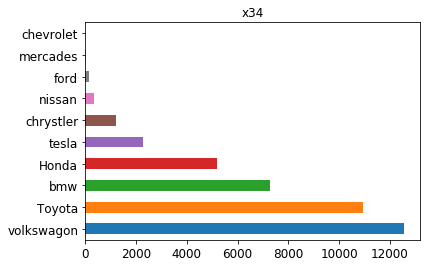

In [8]:
# check the counts for x34
X['x34'].value_counts().plot(kind='barh', fontsize=12).set_title('x34')

Car brand 'Volkswagon' is the most frequent class of x34.

Text(0.5,1,'x35')

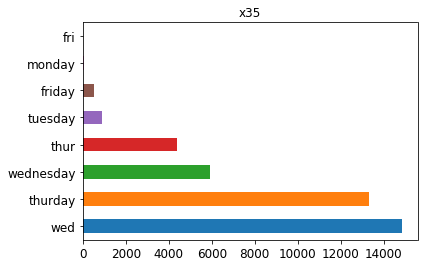

In [9]:
# check the counts for x35
X['x35'].value_counts().plot(kind='barh', fontsize=12).set_title('x35')

'wed' is the most frequent class. Need to convert 'friday' to 'fri', 'thurday' to 'thur' etc.

Text(0.5,1,'x35')

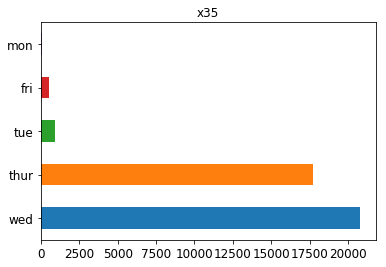

In [10]:
# convert 'friday' to 'fri', 'wednesday' to 'wed' so on
x35_mapping = {'wed':'wed', 'thurday':'thur', 'wednesday':'wed', 'thur':'thur', 'tuesday':'tue', 'friday':'fri',
                 'monday':'mon', 'fri':'fri'}
X['x35'] = X['x35'].map(x35_mapping)
X['x35'].value_counts().plot(kind='barh', fontsize=12).set_title('x35')

In [11]:
# remove '$' and conver x41 to numerical values
X['x41'] = X['x41'].str.replace('$', '', regex=False).astype('float64')

Text(0.5,1,'x45')

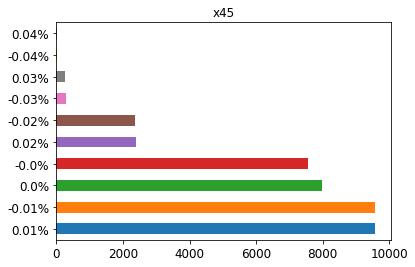

In [12]:
# check the counts for x45
X['x45'].value_counts().plot(kind='barh', fontsize=12).set_title('x45')

Text(0.5,1,'x45')

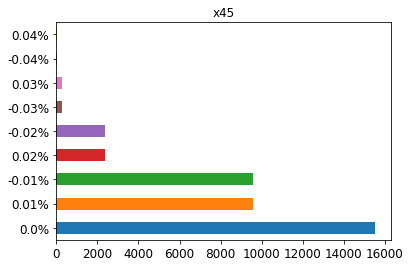

In [13]:
# merge '-0.0%' and '0.0%' to '0.0%'
x45_mapping = {'0.01%':'0.01%', '-0.01%':'-0.01%', '0.0%':'0.0%', '-0.0%':'0.0%', '0.02%':'0.02%', '-0.02%':'-0.02%',
              '-0.03%':'-0.03%', '0.03%':'0.03%', '-0.04%':'-0.04%', '0.04%':'0.04%'}
X['x45'] = X['x45'].map(x45_mapping)
X['x45'].value_counts().plot(kind='barh', fontsize=12).set_title('x45')

Text(0.5,1,'x68')

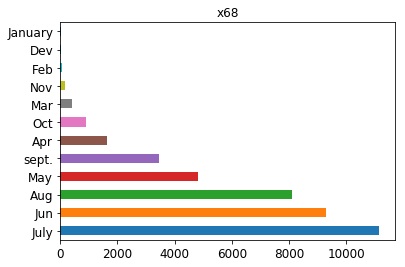

In [14]:
# check the counts for x68
X['x68'].value_counts().plot(kind='barh', fontsize=12).set_title('x68')

Text(0.5,1,'x93')

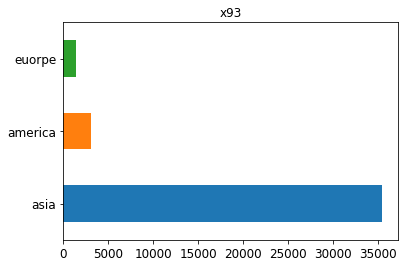

In [15]:
# check the counts for x93
X['x93'].value_counts().plot(kind='barh', fontsize=12).set_title('x93')

'asia' is the majority among all data, much more larger than the sum of the other two.

In [16]:
# see the distribution and info for the categorical data again
X.describe(include=['O'])

,x34,x35,x45,x68,x93
count,39992,39989,39995,39989,39993
unique,10,5,9,12,3
top,volkswagon,wed,0.0%,July,asia
freq,12557,20756,15524,11146,35434


## Preprocess numerical data

In [17]:
# statistics summary of the numerical variables
X.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x99
count,39989.000000,39989.000000,39993.000000,39991.000000,39992.000000,39989.000000,39993.000000,39988.000000,39996.000000,39992.000000,...,39989.000000,39995.000000,39995.000000,39992.000000,39990.000000,39992.000000,39985.000000,39991.000000,39995.000000,39990.000000
mean,6.159970,-3.568111,0.223336,-1.742588,0.079437,-0.535399,0.015483,-0.011955,-3.055506,-0.023167,...,0.004848,-7.472520,-0.026534,0.016619,-0.000084,0.054600,-0.459762,-4.925135,0.033761,0.120155
std,29.098537,17.186748,5.237987,36.601044,21.179065,13.602122,4.110412,2.423051,13.450495,2.472008,...,2.371696,85.885663,9.446348,5.585176,1.135819,22.278277,12.702453,34.931541,5.374336,3.116143
min,-106.809919,-72.864290,-21.508799,-157.569819,-79.900790,-55.050043,-15.955862,-9.299563,-54.415601,-9.674058,...,-9.157992,-375.460243,-36.618364,-24.268022,-4.928351,-101.342320,-57.873114,-140.638773,-22.402508,-13.024105
25%,-13.617383,-15.148354,-3.295204,-26.465502,-14.215354,-9.771613,-2.770450,-1.644516,-12.055884,-1.683043,...,-1.594277,-64.312552,-6.390111,-3.764955,-0.771053,-14.881499,-8.968785,-28.431741,-3.590052,-1.992603
50%,6.247370,-3.660536,0.264994,-1.638876,0.113879,-0.530463,0.015259,-0.002569,-3.069374,-0.039400,...,-0.011211,-5.892459,-0.074239,0.025084,0.001850,0.239447,-0.371605,-5.023371,0.031702,0.115059
75%,25.570242,7.807474,3.761013,23.044686,14.365631,8.673525,2.770460,1.621142,5.910663,1.636558,...,1.600405,50.873797,6.360710,3.784911,0.767160,15.109761,8.128631,18.412348,3.663242,2.230546
max,134.592465,71.071223,21.060130,145.566756,89.856546,52.628375,18.546313,11.919020,54.262047,9.492780,...,9.731345,336.414571,42.835142,23.505468,4.792344,92.442885,52.159468,147.391902,21.614385,13.208294


Any missing values? True


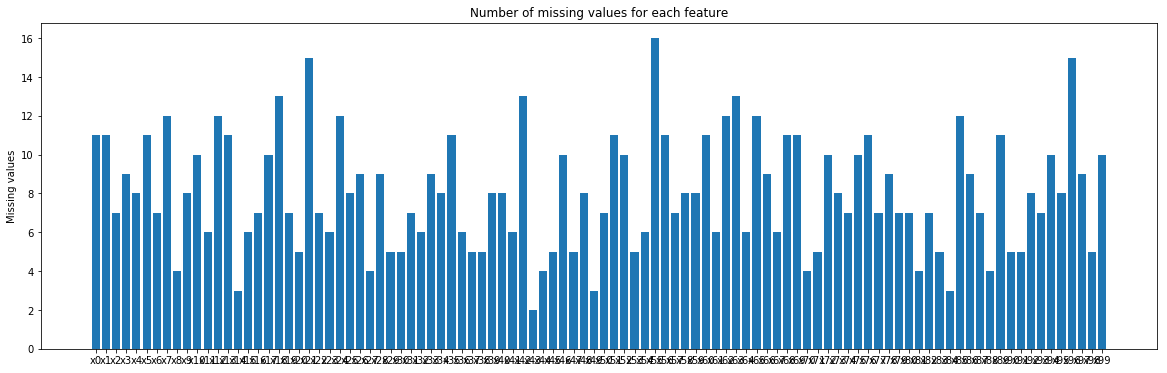

In [18]:
# check missing value
print("Any missing values?", X.isnull().values.any())

# count the number of missing value for each feature
num_of_missing_value = X.isnull().sum()
plt.figure(figsize=(20,6))
plt.bar(x=num_of_missing_value.index, height=num_of_missing_value.values)
plt.ylabel('Missing values')
plt.title('Number of missing values for each feature')
 
plt.show()

Summarize number of missing values for each feature. From the plot we can see that response variable y doesn't have missing value. Overall, all the features only have a small number of missing values (less than 16). So I'll imputing missing values instead of deleting any features.

In [19]:
# check balance of y
print(y.value_counts())

# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3,random_state = 42, shuffle=True)

# quick look at the train data
X_train.head()

0    31880
1     8120
Name: y, dtype: int64


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
25353,-8.563586,5.435557,-1.504679,0.343222,-10.584851,-14.237021,-1.005271,0.153876,-5.844729,1.557687,...,-135.171327,-1.431403,5.783182,euorpe,-0.203064,-36.294357,-17.091361,28.988695,-8.789284,2.618071
25345,7.213903,-17.870397,-3.685137,33.064027,34.622677,1.861846,-2.322878,3.317763,6.495492,1.434307,...,73.929070,-1.454155,3.295312,asia,-0.835502,8.475902,-16.335395,12.568083,-4.666049,3.513758
6846,16.897635,25.832390,-0.806877,34.819313,-5.635905,7.157500,-1.652362,-1.822059,10.157303,-0.090437,...,-126.743908,5.901171,-7.390365,asia,1.067952,17.708499,-6.053060,-31.245151,2.875697,0.401172
5227,-1.565166,8.604940,5.756508,-37.458834,-7.871727,1.873589,3.419059,-0.685985,-19.584835,-2.209003,...,-76.582085,2.716217,-2.798535,asia,-0.131425,-20.237148,-0.335398,8.070695,10.800442,0.450779
29300,-15.899992,-14.808737,-5.527872,50.717721,2.751823,-3.081914,-0.757675,-0.297167,9.745456,0.318763,...,-66.939655,-5.660118,-6.662371,asia,-0.634636,-41.816761,3.410783,22.332020,-0.866737,0.949796


In [20]:
print('\n Shape of training data:', X_train.shape)
print('\n Shape of test data:', X_test.shape)


 Shape of training data: (28000, 100)

 Shape of test data: (12000, 100)


## EDA

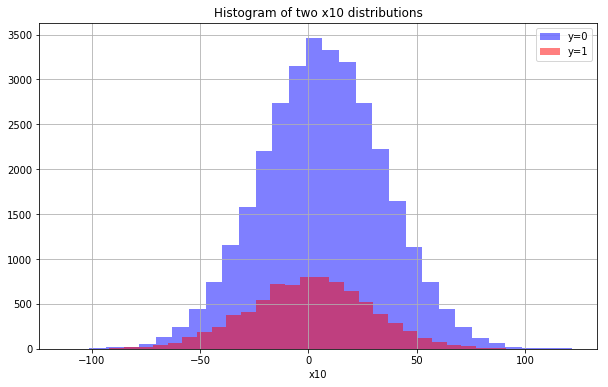

In [21]:
# creat a histogram for x10 for each group of y 
plt.figure(figsize=(10,6))
data[data['y']==0]['x10'].hist(bins=30, grid=True, color='blue', alpha=0.5, label='y=0')
data[data['y']==1]['x10'].hist(bins=30, grid=True, color='red', alpha=0.5, label='y=1')
plt.legend()
plt.title("Histogram of two x10 distributions")
plt.xlabel("x10")
plt.show()

Bell shape curves. The two histograms overlap a lot, which indicates x10 doesn't help too much to predict.

In [22]:
#sns.pairplot(X_train)

## Transformation piplines
#### Impute, standardize numerical features and impute, encode categorical features for train and test data

In [23]:
# split numercial and categorical features 
index = [34,35,45,68,93]
num_attribs = list(np.delete(X_train.columns, index))
cat_attribs = ['x34','x35','x45','x68','x93']

In [24]:
# pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

# pipeline for categorical featrues
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

# combine two pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipelien', cat_pipeline),
])

# transform X_train and X_test
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

print('\n Shape of X_train_prepared and X_test_prepared: ', X_train_prepared.shape, X_test_prepared.shape)


 Shape of X_train_prepared and X_test_prepared:  (28000, 134) (12000, 134)


## Fit Random Forest

#### Part one: fit and save model

In [91]:
# RandomSearchCV for random forest
param_dist = {'n_estimators': [10,50,100,200], 'max_features': ['sqrt',2,5,9,15], 'max_depth': [1,3,6,10,15],
    'min_samples_leaf': [3,5,8,12], 'min_samples_split':[2,5,9,14,20], 'class_weight':[None, 'balanced']} 

# run randomized search
n_iter_search = 20

forest_cla = RandomForestClassifier()
random_search = RandomizedSearchCV(forest_cla, param_distributions=param_dist, n_iter=n_iter_search, 
                                 scoring='neg_mean_squared_error')

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_prepared, y_train)
timer(start_time) # timing ends here for "start_time" variable

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 Time taken: 0 hours 4 minutes and 5.87 seconds.


In [93]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=9,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=12,
            min_samples_split=14, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [ ]:
final_model = random_search.best_estimator_

# save model using joblib
joblib.dump(final_model, 'rf_final.pkl')

#### Part two: load and apply the model

In [30]:
# load model 
rf_loaded = joblib.load('rf_final.pkl')

In [31]:
final_pred_train = rf_loaded.predict(X_train_prepared)

final_mse = mean_squared_error(y_train, final_pred_train)
print('\n The accuracy of training data is :', 1-final_mse)


 The accuracy of training data is : 0.9815357142857143


In [32]:
final_pred_test = rf_loaded.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_pred_test)
print('\n The accuracy of test data is :', 1-final_mse)


 The accuracy of test data is : 0.93875


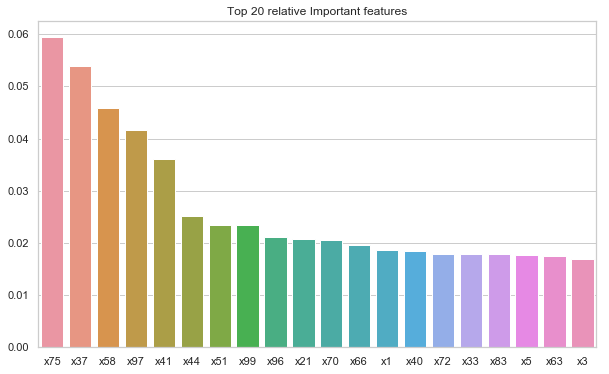

In [35]:
# plot top 20 important features and their relevant importances
plot_feature_importances_rf(20)

In [148]:
info = np.round(100*np.sum(rf_loaded.feature_importances_[0:95]), 2)
print('\n The top 95 important features include', info, '% information of data.')


 The top 95 important features include 98.28 % information of data.


It indicates that I can through away about 30 useless features.

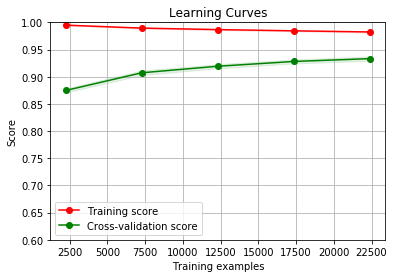

In [118]:
# plot learning curve
Plot_learning_curve(rf_loaded, 'Learning Curves', X_train_prepared, y_train, cv=5)

Training score (red line) decreases slowly. Cross-validation score (green line) increases over time, but there's gap between cross-validation score and training score, indicates high variance (overfitting) scenario.
Reduce complexity of the model or gather more data may help to improve.

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9564
           1       0.88      0.81      0.84      2436

   micro avg       0.94      0.94      0.94     12000
   macro avg       0.92      0.89      0.90     12000
weighted avg       0.94      0.94      0.94     12000

Confusion Matrix for test data:

 [[9295  269]
 [ 466 1970]]


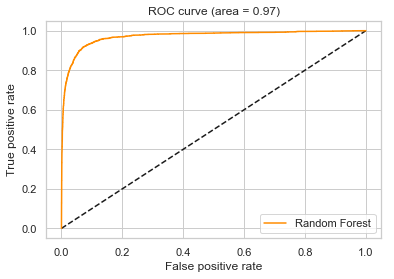

In [149]:
print(classification_report(y_test, final_pred_test))

print('Confusion Matrix for test data:')
print('\n', confusion_matrix(y_test, final_pred_test))

# ROC curve 
ROC_Curve_rf(rf_loaded, X_test_prepared, y_test)

## Fit Multilayer Perceptron

#### Part one: fit and save model

In [105]:
# build sequential model 
model = keras.Sequential([
    keras.layers.Dense(150, input_dim=134, activation=tf.nn.relu),
    # Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time,
    # which helps prevent overfitting.
    keras.layers.Dropout(0.5),
    keras.layers.Dense(150, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(150, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# compile model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# fit model
model.fit(X_train_prepared, y_train.values, epochs=5)

Epoch 1/5
28000/28000 [==============================] - 3s 110us/step - loss: 0.3498 - acc: 0.8556
Epoch 2/5
28000/28000 [==============================] - 2s 80us/step - loss: 0.1930 - acc: 0.9321
Epoch 3/5
28000/28000 [==============================] - 2s 79us/step - loss: 0.1348 - acc: 0.9586
Epoch 4/5
28000/28000 [==============================] - 2s 81us/step - loss: 0.1104 - acc: 0.9698
Epoch 5/5
28000/28000 [==============================] - 2s 83us/step - loss: 0.1023 - acc: 0.9741


In [150]:
# save model
model.save('mlp_model.h5')

#### Part two: load and apply model

In [151]:
# load model 
mlp_loaded = load_model('mlp_model.h5')

28000/28000 [==============================] - 1s 37us/step

 The accuracy of training data is : 0.9895714285714285


12000/12000 [==============================] - 0s 34us/step

 The accuracy of test data is : 0.9818333333333333

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9564
           1       0.98      0.93      0.95      2436

   micro avg       0.98      0.98      0.98     12000
   macro avg       0.98      0.96      0.97     12000
weighted avg       0.98      0.98      0.98     12000


 Confusion Matrix for test data:

 [[9524   40]
 [ 178 2258]]


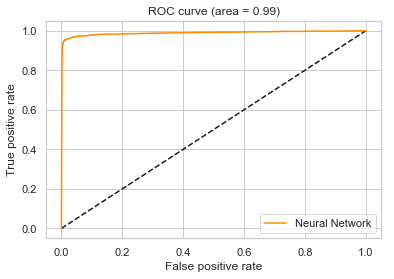

In [154]:
# model evaluation and confusion matrix
# model_pred_train = mlp_loaded.predict_classes(X_train_prepared)
# model_mse = mean_squared_error(y_train, model_pred_train)
train_loss, train_acc = mlp_loaded.evaluate(X_train_prepared, y_train)
print('\n The accuracy of training data is :', train_acc)
print('\n')

#model_pred_test = mlp_loaded.predict_classes(X_test_prepared)
#model_mse = mean_squared_error(y_test, model_pred_test)
test_loss, test_acc = mlp_loaded.evaluate(X_test_prepared, y_test)
print('\n The accuracy of test data is :', test_acc)

print('\n', classification_report(y_test, model_pred_test))

print('\n Confusion Matrix for test data:')
print('\n', confusion_matrix(y_test, model_pred_test))

# ROC Curve
ROC_Curve_nn(mlp_loaded, X_test_prepared, y_test)

In [25]:
# load model 
rf_loaded = joblib.load('rf_final.pkl')

# load model 
mlp_loaded = load_model('mlp_model.h5')

In [31]:
# Predit the probability for both RandomForest and Neural Network
pred_proba_rf = rf_loaded.predict_proba(X_test_prepared)
pred_proba_nn = mlp_loaded.predict_proba(X_test_prepared)

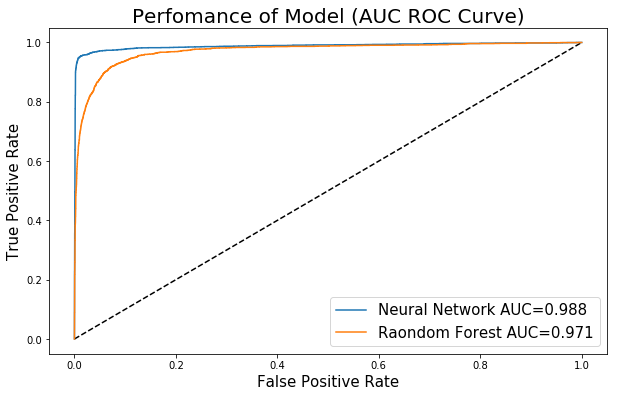

In [37]:
# Caculate the AUC and plot the ROC Curve for both models
fpr_nn, tpr_nn, _ = roc_curve(y_test, pred_proba_nn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_proba_rf[:,1])
auc_nn = roc_auc_score(y_test, pred_proba_nn)
auc_rf = roc_auc_score(y_test, pred_proba_rf[:,1])

plt.figure(figsize = (10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn, tpr_nn, label="Neural Network AUC="+str(round(auc_nn, 3)))
plt.plot(fpr_rf, tpr_rf, label="Raondom Forest AUC="+str(round(auc_rf, 3)))
plt.legend(loc=4, prop={'size': 15})
plt.title("Perfomance of Model (AUC ROC Curve)", fontsize = 20)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.xlabel("False Positive Rate", fontsize = 15)
plt.show()

## Transformation for test data

In [155]:
test = pd.read_csv('../classification_state_farm/exercise_04_test.csv')
test.describe(include=['O'])

,x34,x35,x41,x45,x68,x93
count,9999,9998,10000,9998,10000,9999
unique,10,8,9861,10,12,3
top,volkswagon,wed,$1080.34,0.01%,July,asia
freq,3132,3709,3,2419,2709,8850


Test data also have little missing value. I'll do same transformation for test data before feed them into ML algorithms.

In [156]:
# transform test data in the same way
test_prepared = transformation_test(test)
print('Shape of prepared test data :', test_prepared.shape)

Shape of prepared test data : (10000, 134)


In [163]:
# predictions from random forest
rf_test_prediction = rf_loaded.predict_proba(test_prepared)[:,1]

In [164]:
# predictions from nerual network
nn_test_prediction = mlp_loaded.predict_proba(test_prepared)

In [168]:
# save predictions to csv files
np.savetxt("results1.csv", rf_test_prediction)
np.savetxt("results2.csv", nn_test_prediction)